# Magnacules

The gist:

Create tabletop objects with magnets embedded in a form. These objects interact with other magnets (stick / unstick) in a way that models the interaction of atoms or simple molecules.. and are fun to play with.

More specifically, we wisht to find a fixed (planar) arrangement of permanent magnets such that a test magnet will sit stably (in the plane and with fixed orientation) without touching the fixed arrangement - that is, it will be "bonded" but at a distance.

This is an idea that I got from chemist Dr. Max Mahoney at FLCC who is experimenting with these as a learning tool.
Our goal was to do some numerical exploration, experimentation and optimization before investing in the sometimes expensive larger magnets.

Here are some examples of similar objects in action.

https://www.youtube.com/watch?v=bRDKOcfrI-Y

https://www.grand-illusions.com/inverter-magnet-c2x21140114?PGFLngID=1

In this notebook you will:
- Compute magnetic fields
- Visualize magnetic fields: plt.quiver, mayavi?, blender?
- Construct composite fields
- Attempt to create stable region using trial and error
- Use an optimization routine to construct the deepest potential well given constraints.
- Characterize the sensitivity of this extremum w.r.t. parameters - e.g. if there is 1% error in the central field strength, what is the impact on the extremum?
- Compare perfect dipole with extended body dipole (like you find in a real magnet)
- Use this extended body model to recompute the optimum.

Resources:
- Example of fsolve and other stuff worth looking at. https://kite.com/python/examples/1011/scipy-find-the-roots-of-a-function
- https://pundit.pratt.duke.edu/wiki/Python:Finding_roots
- TODO: link to basic E&M
- TODO: link to Max

"Magnacules" is protected under trademark and may only appear in commercial use when in compliance with very complicated licenses and agreements with author John Mahoney.

## Classes

A secondary goal of this project is to introduce students to the use of `classes` in Python.

Roughly speaking, the Magnacule is an object with a number of features or `attributes`: number of magnets, strength of those magnets, physical configution, maybe other things like material, etc.  The magnacule is also something that a user might want to interact with or learn about in a few standard ways: how strong is the field it generates? where are the minima? what are the characteristics of these minima, etc. 

When dealing with a situation like this, a `class` can be a very convenient and powerful programming approach.
The class can mirror many of these attributes and functionalities.
This can make programming easier to organize and generalize.
It can also make the syntax of its use more transparent.

Some notes:
- The general class `Magnacule` is defined much like a function.
- Particular magnacules with particular parameters and identities are `instances`.
- The `__init__` function is the setup function that is called when you define or instantiate.
```
my_mag = Magnacule(moments=[1, 2], locations=[[1, 2], [4, 3]])
```
- An instance "knows" its own `attributes` (you can, for example, print them).
```
print(my_mag.moments)
```
- The instance is also given certain functionality (its `methods`).
```
my_mag.plot_energy_field()
```
- Pay attention to the `self` argument. This should be the first argument of any class method. It is also how you refer to that instance within the function.

In [1]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

#%config InlineBackend.figure_format='retina' # Use this on a Mac with Retina display
%matplotlib inline

In [27]:
class Magnacule:
    
    def __init__(self, moments=None, locations=None, bodies=None):
        """
        Magnacule = Magnet + Molecule
        
        A Magnacule is a set of magnets in some fixed planar configuration.
        The motivating example is the 'tractor magnet' - a strong center magnet with six oppositely oriented
        satellite magnets. This tractor magnet can hold a 'test' magnet at some radius greater than the body of the
        tractor. In this way, the tractor serves as a model of a molecule and offers some insight into the nature of
        molecular bonding.

        To make a Magnacule, we can specify everything in the instatiation of the object.
        We can also add, remove or modify magnets afterwards.
        We can also use one the Magnacule factories.
        """
        
        # TODO: add attribute self.current_min or something.
        # We seem to compute the min often and it would be nice to have access to that once computed.
        
        if moments is None:
            # Assume that there are no arguments being passed
            pass
        else:
            # Minimum working parameters
            self.N = len(self.moments)
            self.moments = np.array(moments)
            self.locations = np.array(locations)
            
            # Optional parameters
            if bodies is None:
                self.bodies = np.ones(self.N) # radius of each magnet (assuming each magnet is a cylinder)
            else:
                self.bodies = np.array(bodies) # radius of each magnet (assuming each magnet is a cylinder)
        
        # We choose physical units here
        # TODO: Think about what might be a more standard choice.
        self.mu0over4pi = 1.0
        
    def make_hex(self, m_center, m_hex, rad, rad_center=0.5, rad_hex=0.1):
        "This is the arrangement used for the 'tractor magnet'."
        
        self.moments = np.array([m_center] + 6*[m_hex])
        
        angles = 2 * np.pi * (np.arange(0, 6) + 0.5)/6
        self.locations = np.zeros((7,2))
        self.locations[0, :] = [0,0]
        
        self.locations[1:, :] = rad * np.column_stack([np.cos(angles), np.sin(angles)])

        self.N = 7
    
        self.bodies = np.array([rad_center] + 6*[rad_hex])
        
    def print_info(self):
        for ind in range(self.N):
            print(ind, " moment: ", self.moments[ind], "location: ", self.locations[ind])

    def plot_magnet_bodies_1D(self, yslice=0, ax=None):
        # If a magnet body falls within the slice, we show the relevant magnet width (depends on where we slice).

        if ax is None:
            fig = plt.figure(figsize=(8,8))
            ax = plt.gca()
            
        for ind in range(self.N):
            m = self.moments[ind]
            x, y = self.locations[ind, :]
            rad = self.bodies[ind]
            
            dy = np.abs(yslice - y)
            
            if m > 0:
                color = 'red'
            elif m < 0:
                color = 'blue'
            ax.axvspan(x - rad, x + rad, alpha=0.05, color=color)
            
            if dy < rad:
                sub_rad = np.sqrt(rad**2 - dy**2)
                ax.axvspan(x - sub_rad, x + sub_rad, alpha=0.2, color=color)
                
        return ax
        
    def plot_magnet_bodies_2D(self, ax=None):
        if ax is None:
            fig = plt.figure()
            ax = plt.gca()
            
        ax.scatter(self.locations[:, 0], self.locations[:, 1], 1, 'k')
        
        for ind in range(self.N):
            x, y = self.locations[ind, :]
            rad = self.bodies[ind]
            circle = Circle((x, y), rad, facecolor='w', edgecolor='k')
            ax.add_patch(circle)
        ax.set_aspect('equal')
        
        return ax

    def plot_energy_field(self, xlims=None, ylims=None, num_x=200, num_y=200, plot_bodies=True,
                          scaled=True, ax=None, rel_pad=1.0):
        
        # TODO: Try applying a mask to the energy field where the magnets are / or where the field is too strong.
        # This might reduce the dynamic range and make the graph more readable.
        
        mins = np.min(self.locations, axis=0)
        maxs = np.max(self.locations, axis=0)
        
        ds = maxs - mins
        mins = mins - rel_pad * ds
        maxs = maxs + rel_pad * ds
        
        if xlims is None:
            xlims = [mins[0], maxs[0]]            
        if ylims is None:
            ylims = [mins[1], maxs[1]]

        xs = np.linspace(xlims[0], xlims[1], num_x)
        ys = np.linspace(ylims[0], ylims[1], num_y)
        
        X, Y = np.meshgrid(xs, ys)
        
        H_total = self.H(X, Y, scaled=scaled)
            
        if ax is None:
            fig = plt.figure(figsize=(8,8))
            ax = plt.gca()
        else:
            fig = ax.get_figure()
            
        im = ax.imshow(H_total, extent=[xlims[0], xlims[1], ylims[0], ylims[1]])
        fig.colorbar(im, ax=ax)
        
        if plot_bodies:
            self.plot_magnet_bodies_2D(ax=ax)
        
        return ax
    
    def plot_energy_slice(self, xlims=None, yslice=0, num_x=200, scaled=True, ax=None,
                          rel_pad=0.2, x0=1.0, show_half=False):
        
        # ylims are pretty clear here
        # xlims requires some thought
        # control them directly, or do something reasonably based on magnet locations
        if xlims is None:
            xmin = np.min(self.locations[:, 0])
            xmax = np.max(self.locations[:, 0])
        else:
            xmin = xlims[0]
            xmax = xlims[1]
            
        d = xmax - xmin
        xmin -= rel_pad * d
        xmax += rel_pad * d

        if show_half is True:
            xmin = (xmin + xmax)/2
            
        xs = np.linspace(xmin, xmax, num_x)

        H_total = self.H(xs, yslice, scaled=scaled)
            
        if ax is None:
            fig = plt.figure(figsize=(8,8))
            ax = plt.gca()
            
        ax.plot(xs, H_total)

        H_min = np.min(H_total)
        H_max = np.max(H_total)
        
        self.plot_magnet_bodies_1D(yslice=yslice, ax=ax)
            
        res = my_mag.find_energy_min_hslice(x0=x0, yslice=yslice, scaled=scaled)
        if res.success == True:
            ax.scatter(res.x, res.fun, 20, 'r', facecolor='w')
#            ax.vlines(res.x, H_min/2, H_max/2, 'k', 'dotted')

        ax.set_xlim((xmin, xmax))
#         ax.set_xlim(xlims)
        return res

    def H(self, test_x, test_y, scaled=False, sign=+1, test_moment=1.0):
        """Evaluate the magnetic interaction energy between the magnacule and a test magnet.
        The test magnet will be a dipole located in the z=0 plane and pointing in the z-direction.
        
        This function can accept three input formats
        
        H(2.0, 5.0) - a single point
        H([2.0, 2.2, 2.4], 5.0) - one coordinate is a 1D numpy array.
        H(X, Y) - where X, Y = np.meshgrid(x, y)
        
        The `sign' parameter is used to flip the output to -H. 
        This is useful for maximization.
        
        TODO: Should we catch and handle the case where both `x' and `y' inputs are 1D np arrays? (convert to mesh)
        """
        H_total = 0
        
        # Here the use of `errstate' ignores division by zero within the `with' scope.
        # This is useful because it is not uncommon to find radius == 0.
        with np.errstate(divide='ignore',invalid='ignore'):
            for ind in range(self.N):
                m = self.moments[ind]
                x, y = self.locations[ind, :]
                r = np.sqrt((test_x - x)**2 + (test_y - y)**2)
#                 H = self.mu0over4pi * test_moment * m / r**3
                H = self.mu0over4pi * test_moment * m / r**3
                H_total += H

        if scaled:
            H_total = np.arctan(H_total)
            
        return sign*H_total

    def find_energy_min_hslice(self, x0=None, yslice=0, scaled=True):
        "Find the position along some y=y0 slice where the energy is a local min."
        res = minimize(fun=self.H, x0=x0, args=(yslice, scaled), method='Nelder-Mead',
                       options={'xtol': 1e-8, 'disp': False})
        return res
    
    def find_energy_max_hslice(self, x0=None, yslice=0, scaled=True):
        "Find the position along some y=y0 slice where the energy is a local max."
        sign = -1
        res = minimize(fun=self.H, x0=x0, args=(yslice, scaled, sign), method='Nelder-Mead',
                       options={'xtol': 1e-8, 'disp': False})
        return res
    
    def radial_stability(self, x0):
        """Compute the quadratic approximation at the energy min in the radial direction.
        
        Assuming y = 1/2 * k * (dx)**2, 
        we report the estimated `k' value.
        
        Since the potential wells seem to often be very asymmetric, we report two values:
        one for the inner direction and one for the outer.
        
        TODO: optionally accept a precomputed min - maybe the res object
        """
        
        res = self.find_energy_min_hslice(x0=x0, yslice=0, scaled=True)

        H = self.H(res.x, 0)
        # TODO: Do we really want the just the local quadratic form?
        # If we want to detect the asymmetry, we really need to use larger dx values like x/4.
        dx = res.x / 4

        H_inner = self.H(res.x - dx, 0)

        H_outer = self.H(res.x + dx, 0)
        
        rad_stab_inner = 2*(H_inner - H)/dx**2
        rad_stab_outer = 2*(H_outer - H)/dx**2
        
        return rad_stab_inner, rad_stab_outer
    
    def transverse_stability(self, x0):
        res = self.find_energy_min_hslice(x0=x0, yslice=0, scaled=True)
        
        H = self.H(res.x, 0)
        # TODO: Not sure if this is the best way to estimate
        dy = res.x / 10

        H_A = self.H(res.x, +dy)

        H_B = self.H(res.x, -dy)
        
        trans_stab_A = 2*(H_A - H)/dy**2
        trans_stab_B = 2*(H_B - H)/dy**2
        
        return trans_stab_A, trans_stab_B
        return 

Hard core energy: 2.0529604269579784
Ionization energy: 0.7089865383689962


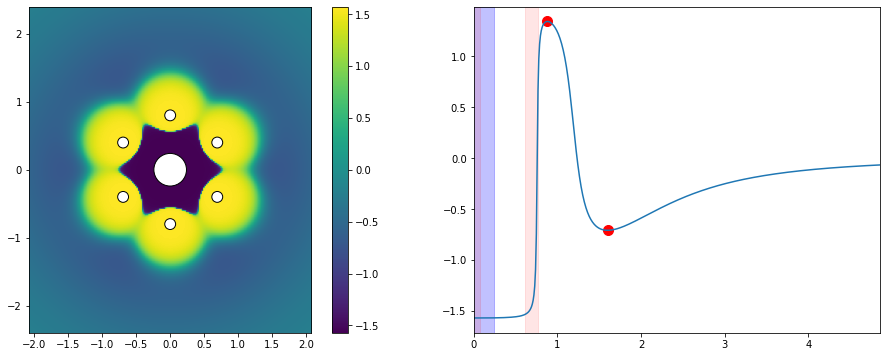

In [31]:
# Make an empty Magnacule
my_mag = Magnacule()

# Configure as a "hex-tractor"
my_mag.make_hex(m_center=-14, m_hex=1, rad=0.8, rad_center=0.24, rad_hex=0.08)

# Plot
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

# Plot energy field in 2D
my_mag.plot_energy_field(ax=ax[0], plot_bodies=True)

# Plot energy in 1D slice along x axis
my_mag.plot_energy_slice(ax=ax[1], num_x=500, rel_pad=3, yslice=0.0, x0=2.0, scaled=True, show_half=True)

# Mark min and max
min_res = my_mag.find_energy_min_hslice(x0=2.0, yslice=0, scaled=True)
max_res = my_mag.find_energy_max_hslice(x0=1.5, yslice=0, scaled=True)

ax[1].scatter(min_res.x, min_res.fun, s=100, c='r', marker='o')
ax[1].scatter(max_res.x, -max_res.fun, s=100, c='r', marker='o')

#print(min_res)
#print(max_res)
print("Hard core energy: {}".format(-1.0*max_res.fun - min_res.fun))
print("Ionization energy: {}".format(-1.0 * min_res.fun))

### Try different combinations

Vary the radius at which the hex magnets are placed *and the ratio between the center and hex magnet strengths.

Which combination leads to the most desirable result?

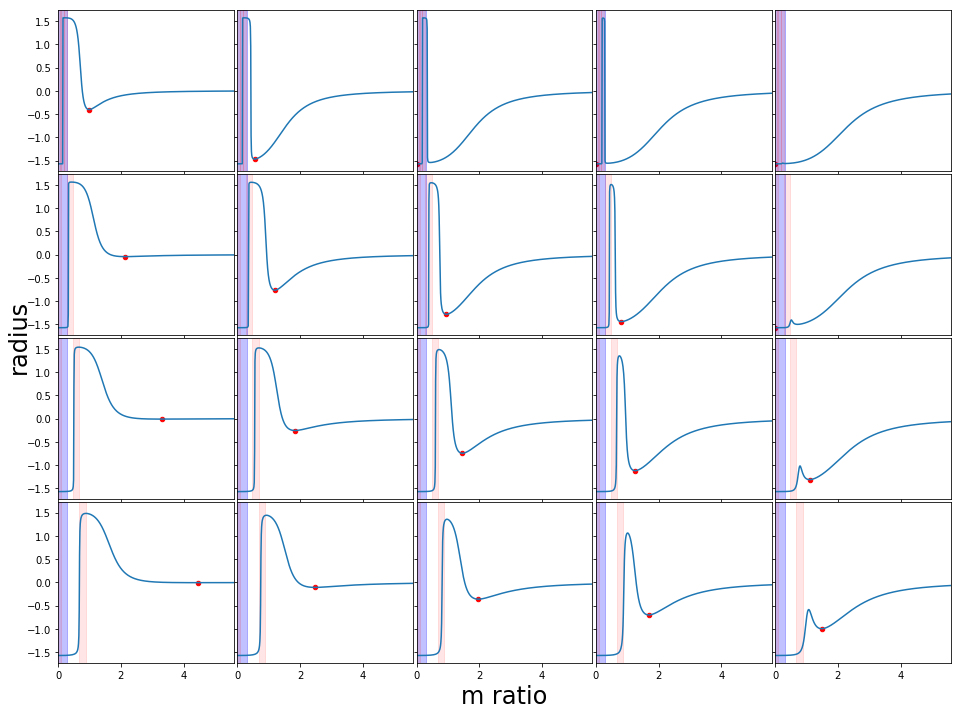

In [33]:
# Make a mosaic of slice plots
rads = np.linspace(0.2, 0.9, 4)
m_ratios = np.linspace(7, 18, 5)

m_hex = 1.0
xlims = [-4, 4]

fig, ax = plt.subplots(nrows=len(rads), ncols=len(m_ratios), figsize=(16,12), sharex=True, sharey=True, 
                       gridspec_kw={'wspace':0.02, 'hspace':0.02})
label_ax = fig.add_subplot(111, frameon=False)
label_ax.tick_params(labelcolor="none", bottom=False, left=False)

for rad_ind, rad in enumerate(rads):
    for m_ratio_ind, m_ratio in enumerate(m_ratios):

        my_mag = Magnacule()
        my_mag.make_hex(m_center=-m_ratio*m_hex, m_hex=m_hex, rad=rad, rad_center=0.3, rad_hex=0.1)

        res = my_mag.plot_energy_slice(ax=ax[rad_ind, m_ratio_ind], yslice=0, num_x=500, x0=1.5, xlims=xlims, show_half=True)

label_ax.set_xlabel('m ratio', size=24);
label_ax.set_ylabel('radius', size=24);

In [ ]:
fig.savefig("radius_vs_m_ratio.png")

### Consider additional features and quantify via heatmaps.

In [35]:
rads = np.linspace(0.05, 0.7, 20)
m_ratios = np.linspace(6, 20, 20)

m_hex = 1.0

stable_xs = np.empty((len(rads), len(m_ratios)))
stable_xs[:] = np.nan

rad_stab_inner = np.empty((len(rads), len(m_ratios)))
rad_stab_inner[:] = np.nan

rad_stab_outer = np.empty((len(rads), len(m_ratios)))
rad_stab_outer[:] = np.nan

ionization_energy = np.empty((len(rads), len(m_ratios)))
ionization_energy[:] = np.nan

barrier_height = np.empty((len(rads), len(m_ratios)))
barrier_height[:] = np.nan

for rad_ind, rad in enumerate(rads):
    for m_ratio_ind, m_ratio in enumerate(m_ratios):

        my_mag = Magnacule()
        my_mag.make_hex(m_center=-m_ratio*m_hex, m_hex=m_hex, rad=rad, rad_center=0.3, rad_hex=0.1)

        min_res = my_mag.find_energy_min_hslice(x0=1.0, scaled=True)
        
        if min_res.success == True and min_res.x >= 0.05 and min_res.x < 10.0:
            stable_xs[rad_ind, m_ratio_ind] = min_res.x
            rs_inner, rs_outer = my_mag.radial_stability(x0=min_res.x)
            rad_stab_inner[rad_ind, m_ratio_ind] = rs_inner
            rad_stab_outer[rad_ind, m_ratio_ind] = rs_outer
            ionization_energy[rad_ind, m_ratio_ind] = - 1.0 * min_res.fun
            max_res = my_mag.find_energy_max_hslice(x0=0.9*min_res.x, scaled=True)
            barrier_height[rad_ind, m_ratio_ind] = -1.0*max_res.fun - min_res.fun

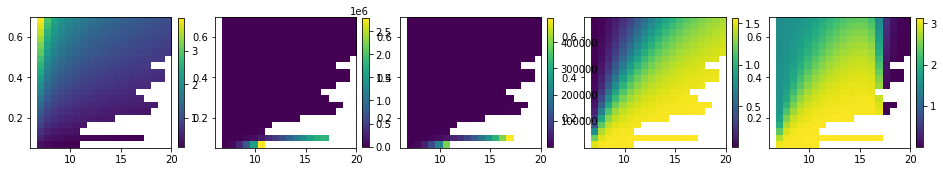

In [36]:
fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(16, 4))

im = ax[0].imshow(stable_xs, origin='lower', extent=[m_ratios[0], m_ratios[-1], rads[0], rads[-1]])
fig.colorbar(im, ax=ax[0], fraction=0.042, pad=0.04)
ax[0].set_aspect(20)

im = ax[1].imshow(rad_stab_inner, origin='lower', extent=[m_ratios[0], m_ratios[-1], rads[0], rads[-1]])
fig.colorbar(im, ax=ax[1], fraction=0.042, pad=0.04)
ax[1].set_aspect(20)

im = ax[2].imshow(rad_stab_outer, origin='lower', extent=[m_ratios[0], m_ratios[-1], rads[0], rads[-1]])
fig.colorbar(im, ax=ax[2], fraction=0.042, pad=0.04)
ax[2].set_aspect(20)

im = ax[3].imshow(ionization_energy, origin='lower', extent=[m_ratios[0], m_ratios[-1], rads[0], rads[-1]])
fig.colorbar(im, ax=ax[3], fraction=0.042, pad=0.04)
ax[3].set_aspect(20)

im = ax[4].imshow(barrier_height, origin='lower', extent=[m_ratios[0], m_ratios[-1], rads[0], rads[-1]])
fig.colorbar(im, ax=ax[4], fraction=0.042, pad=0.04)
#plt.colorbar(im, cax = fig.add_axes([0.78, 0.5, 0.03, 0.38]))
ax[4].set_aspect(20)

### Things to try:

- Do more accounting for the constraints around the physical bodies. What space do the magnets occupy? How much space do we need to allot for the support structure around them? How big is the test magnet?
- Finding extrema seems to work OK but not great. It seems this depends on the initial guess. Work on this. Maybe we could have a function that suggests an initial guess for min and max based on the magnet locations - eg at 1.2 * max magnet radius.
- The energies computed are based on the assumption of a point dipole. In reality, magnets are extended bodies and their field is more like the sum of many point dipoles. We could offer a more sophisticated computation of energy.
- Real magnets will come with some variation in strength (and also orientation). It could be useful to include this information. For instance, if we find an optimal magnet configuration given a set of input magnets, and we have some observed variation in the magnets, what will be the consequent variation in the function of the product magnacule?
- Create a video (in real time) that shows the behavior of a test magnet in the context of a hex tractor being controlled by a "human". In the Youtube video, we see the behavior of the test magnet - as we move the tractor, the test follows and jiggles a bit. Show that this behavior is reproduced by our construction. Don't forget friction!
- Think about how a magnacule might interact with another magnacule.
- Implement a few designs other than the "hex tractor".
- Put many magnacules together in a 2D "reaction" and watch what happens!

# Stable regions of a magnetic field.. are those even possible??

The answer is: Earnshaw's theorem tells you about when such stability is not possible. 
There are assumptions in the theorem that you can break to then create stability.
One is pseudo-levitation where you constrain the motion of the magnet in some way (like only allowing it to slide on a surface).

TODO: Include some discussion here about electric vs magnetic, theorems that forbid magnetic stability.
Earnshaw theorem
https://en.wikipedia.org/wiki/Earnshaw%27s_theorem
https://en.wikipedia.org/wiki/Magnetic_levitation#Mechanical_constraint_(pseudo-levitation)